In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=coarse_crop)
generators = camvid11.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


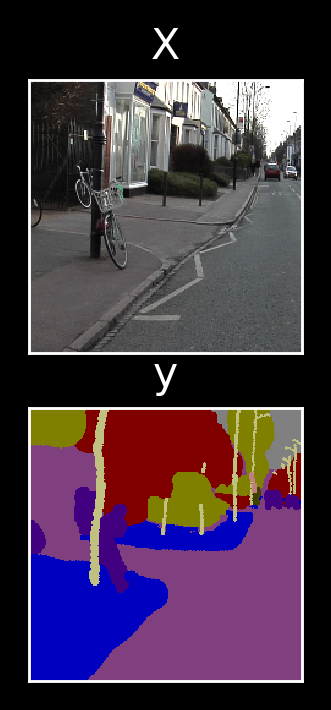

In [7]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [8]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    learning_rate=1e-3,
)

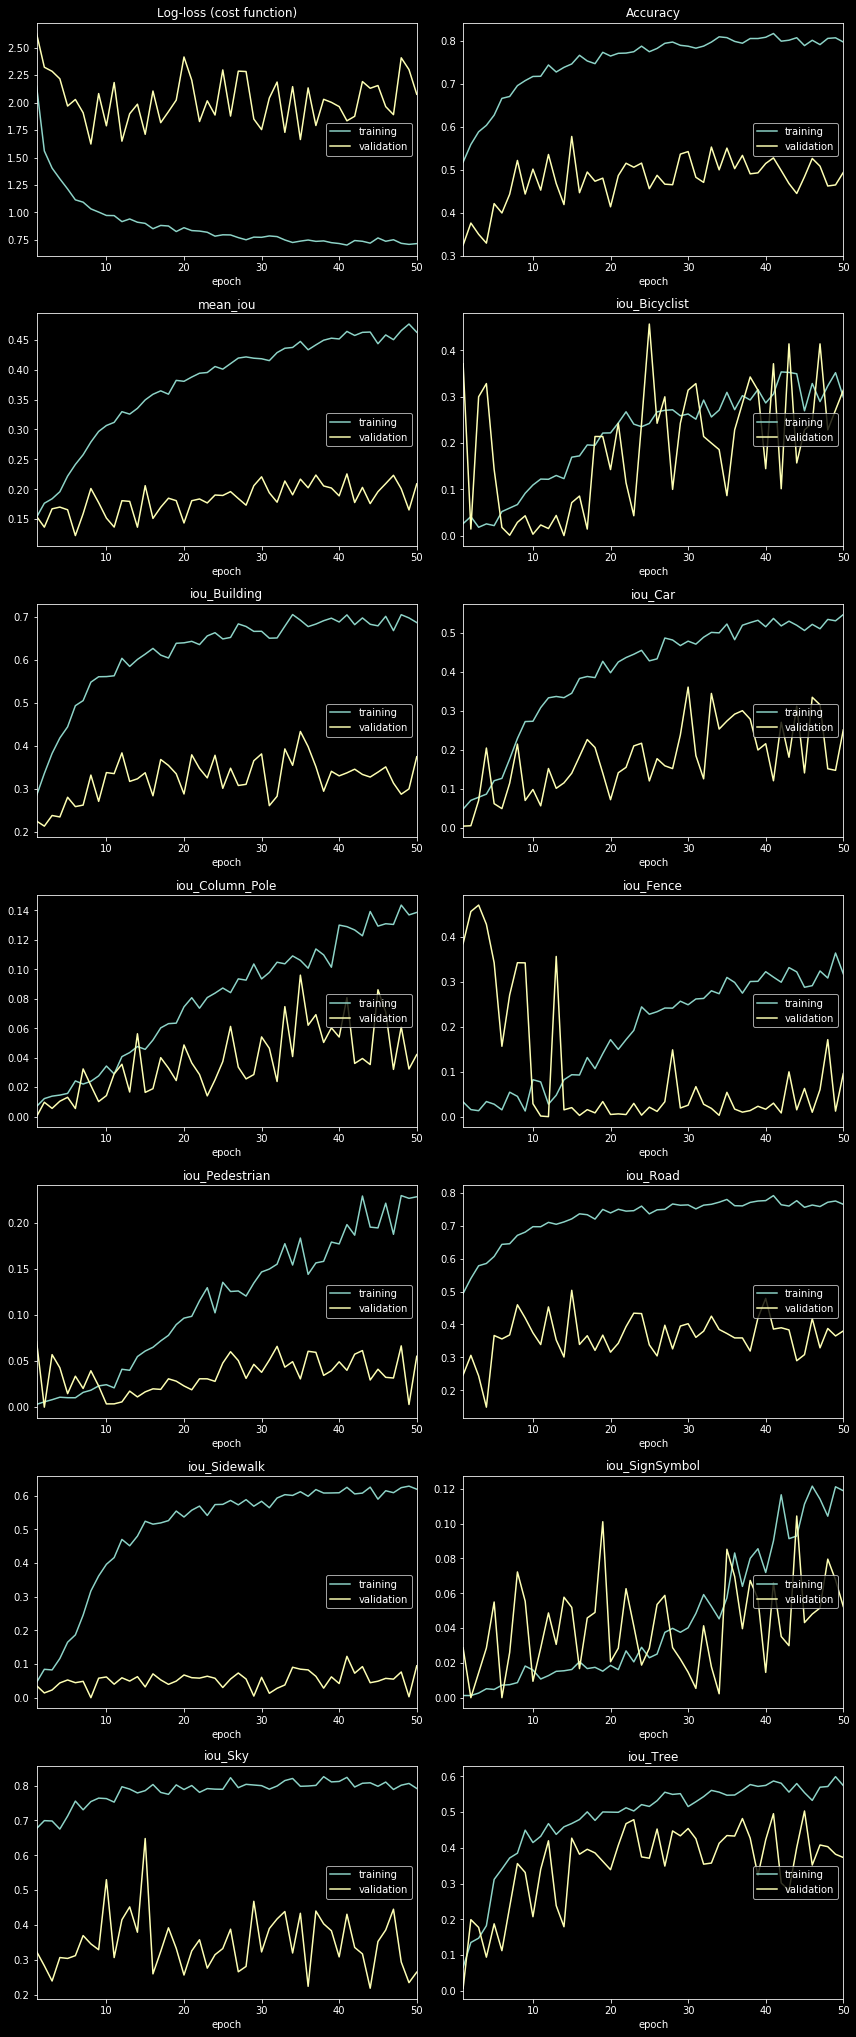

In [9]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [10]:
history_to_results(history)

,train,val
acc,0.798000,0.493850
Bicyclist,0.299356,0.314286
Building,0.686217,0.374410
Car,0.547382,0.251954
Column_Pole,0.138684,0.042150
Fence,0.318471,0.096344
Pedestrian,0.228721,0.055335
Road,0.765489,0.380376
Sidewalk,0.619264,0.095093
SignSymbol,0.118896,0.052406


In [11]:
metrics = model.evaluate_generator(generators['validation'], steps=210)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

,val
loss,1.444811
acc,0.587913
mean_iou,0.246485
iou_Bicyclist,0.228571
iou_Building,0.437707
iou_Car,0.320982
iou_Column_Pole,0.065224
iou_Fence,0.095347
iou_Pedestrian,0.070232
iou_Road,0.454633


In [12]:
X, y = next(generators['training'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

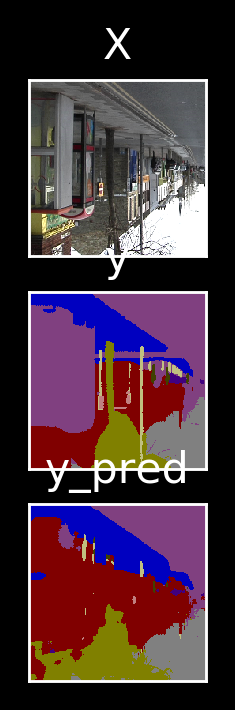

In [13]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

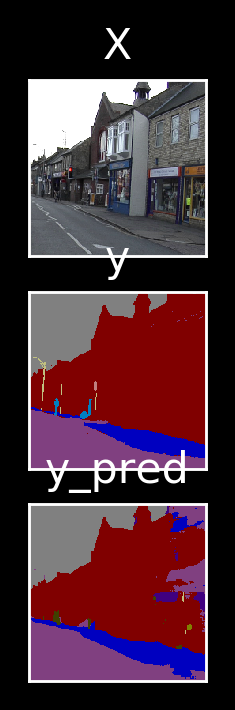

In [14]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

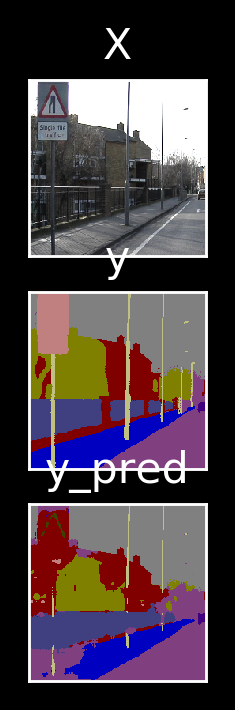

In [15]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

In [16]:
X, y = next(generators['validation'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

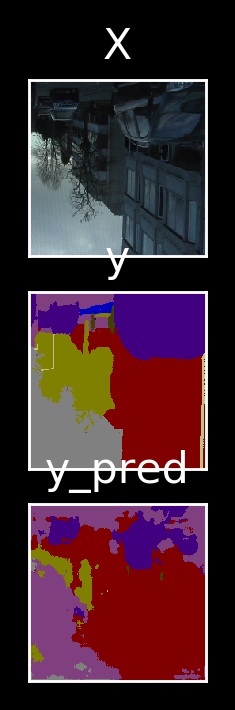

In [17]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

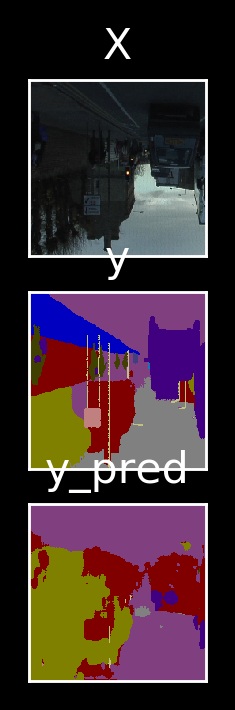

In [18]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

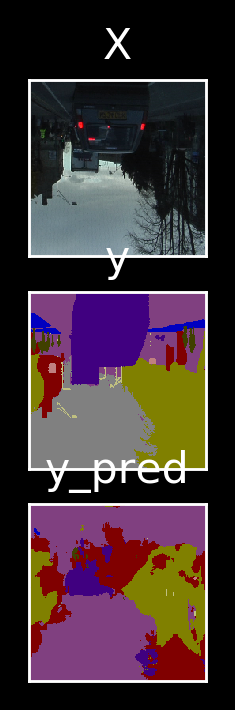

In [19]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

## Save Model

In [20]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid11-coarse.h5')

# Clear Session

remove the current model from memory.

In [21]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [22]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=fine_crop, batch_size=1)
generators = camvid11.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


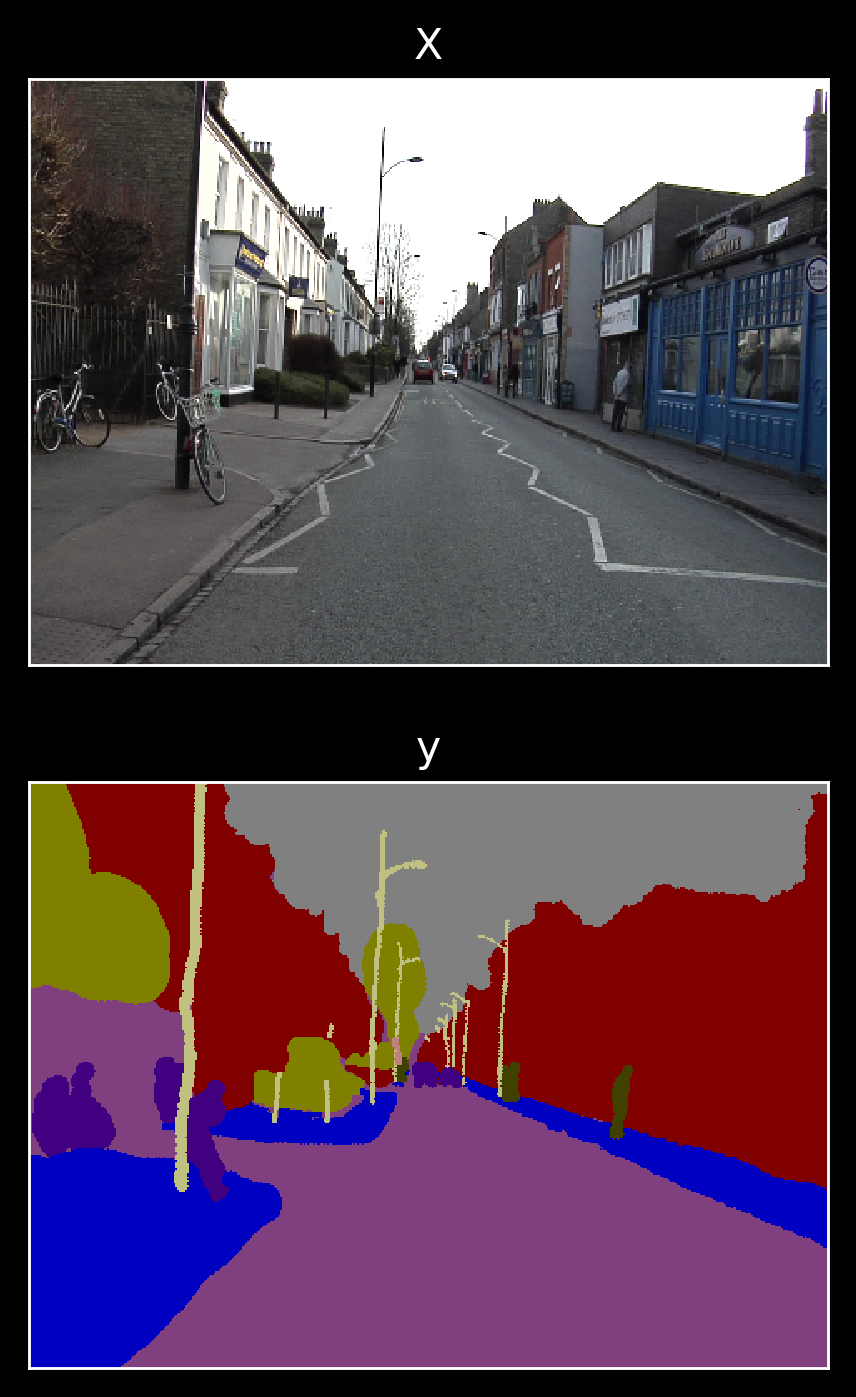

In [23]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [24]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid11-coarse.h5')

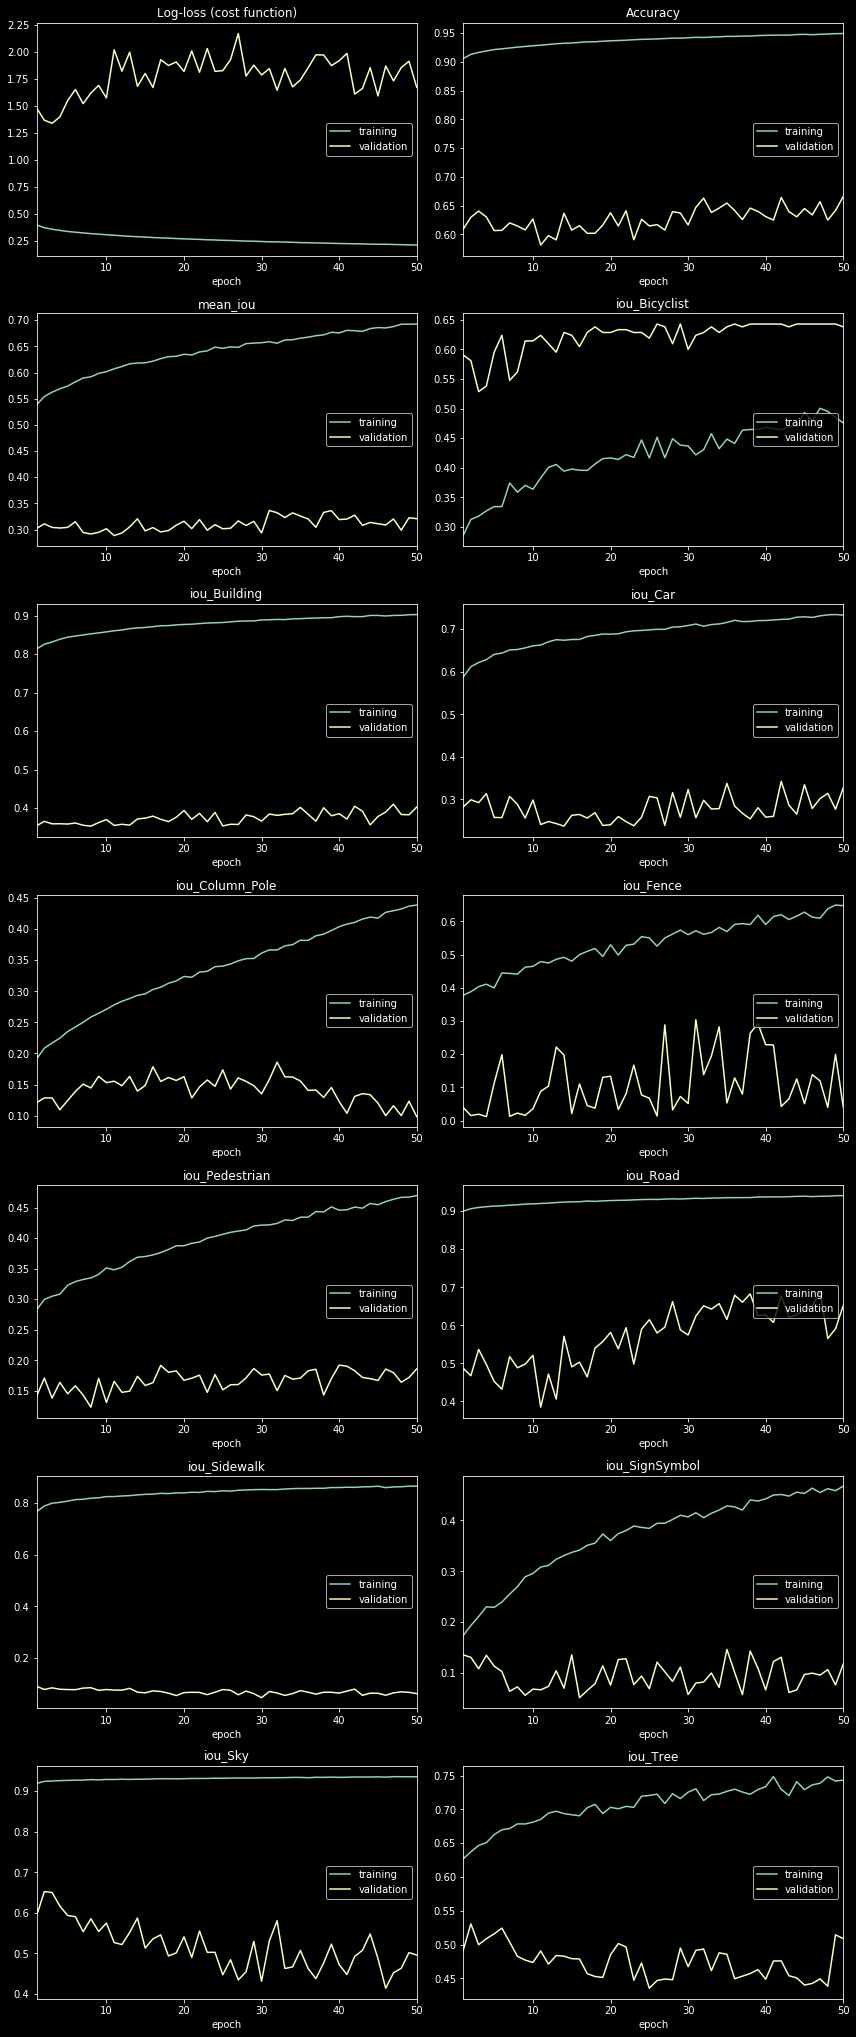

In [25]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=491,
    validation_data=generators['validation'],
    validation_steps=210,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [26]:
history_to_results(history)

,train,val
acc,0.949364,0.665945
Bicyclist,0.475679,0.638095
Building,0.902810,0.402677
Car,0.733180,0.327057
Column_Pole,0.438529,0.098406
Fence,0.647358,0.040443
Pedestrian,0.469512,0.185797
Road,0.940836,0.651807
Sidewalk,0.864832,0.062227
SignSymbol,0.467646,0.117508


In [27]:
metrics = tune_model.evaluate_generator(generators['validation'], steps=210)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

,val
loss,1.645157
acc,0.669579
mean_iou,0.321581
iou_Bicyclist,0.647619
iou_Building,0.407584
iou_Car,0.333378
iou_Column_Pole,0.098502
iou_Fence,0.036177
iou_Pedestrian,0.170564
iou_Road,0.657058


In [28]:
X, y = next(generators['training'])
y = camvid11.unmap(y)
p = tune_model.predict(X)
p = camvid11.unmap(p)

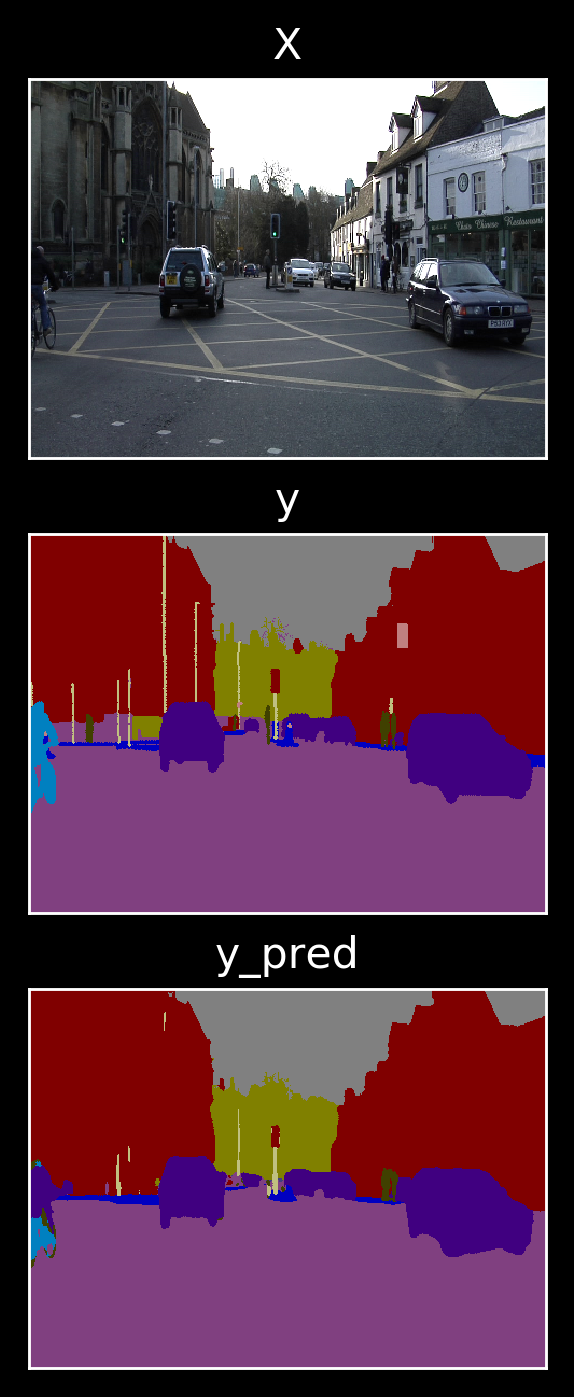

In [29]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [30]:
X, y = next(generators['validation'])
y = camvid11.unmap(y)
p = tune_model.predict(X)
p = camvid11.unmap(p)

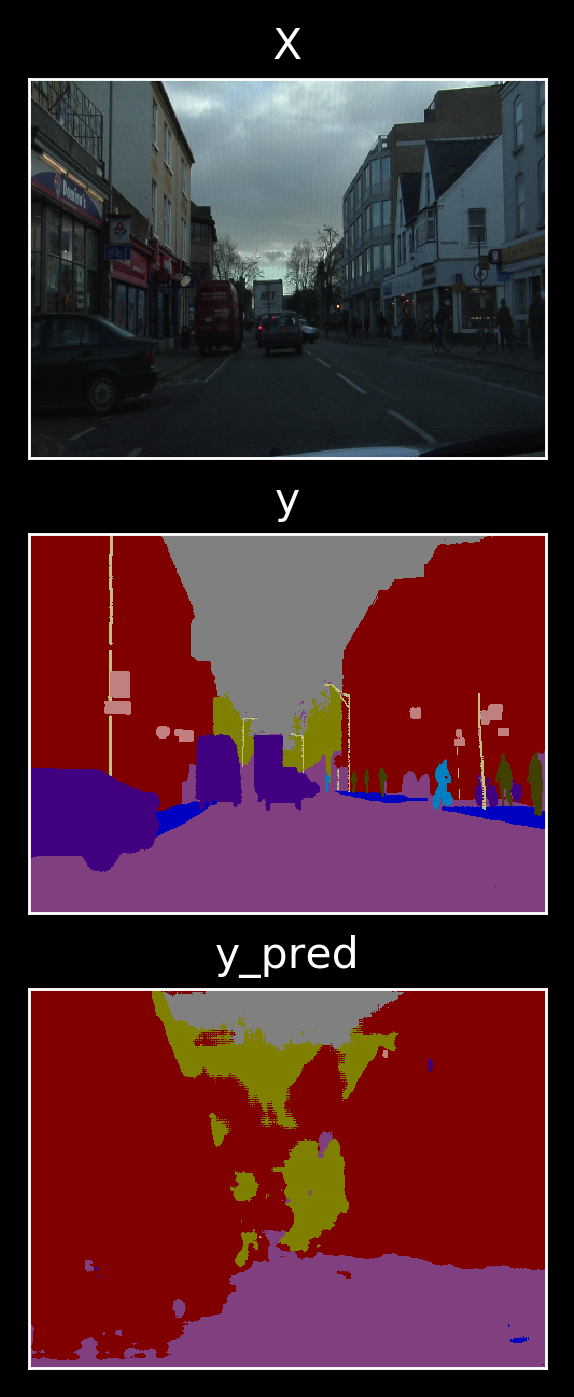

In [31]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [32]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid11-fine.h5')